In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm
import numpy as np
import warnings
import os

# ===================================================================
# STEP 1: 최종 실험 환경 설정
# ===================================================================

# --- 하이퍼파라미터 ---
BATCH_SIZE = 64
BLOCK_SIZE = 64
MAX_ITERS = 30000 
EVAL_INTERVAL = 1000
LOG_INTERVAL = 100 # 모든 로그 기록 주기
LEARNING_RATE = 5e-4 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_ITERS = 200
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2
WARMUP_ITERS = 2000
LR_DECAY_ITERS = 30000
MIN_LR = 5e-5

# --- 최종 실험 그룹 및 시드 정의 ---
SEEDS = [42]
EXPERIMENTS = {
    "Control(STE)": {
        "use_regularizer": False, "lambda_reg": 0.0, "target_score": 0.0
    },
    "Forced_Chaos(STE)": {
        "use_regularizer": True, "lambda_reg": 1.0, "target_score": 2.0
    },
    "Forced_Stability(STE)": {
        "use_regularizer": True, "lambda_reg": 1.0, "target_score": 0.0010
    }
}

# ===================================================================
# STEP 2: 모델, 분석, 훈련 로직 (STE 기반 HCD 추가)
# ===================================================================

def prepare_data(device):
    # ... (이전과 동일)
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    # ... (이전과 동일)
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
    
def _init_weights(module):
    # ... (이전과 동일)
    if isinstance(module, (nn.Linear)):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None: torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

# --- 모델 아키텍처 (이전과 동일) ---
class UnitCircleNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, z):
        z1, z2 = z[..., 0:2], z[..., 2:4]
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        return torch.cat([z1 / (norm1 + self.epsilon), z2 / (norm2 + self.epsilon)], dim=-1)

class EncoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, x): return self.normalizer(self.net(x))

class LatentDynamicsDirect4D(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 1024), nn.GELU(), nn.Dropout(dropout), nn.Linear(1024, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, z): return self.normalizer(self.net(z))

class DecoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 4 * d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4 * d_model, d_model))
    def forward(self, z): return self.net(z)

class LatentTorusTransformerBlockV3(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(n_embd), nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.encoder = EncoderV3(n_embd, dropout)
        self.latent_dynamics = LatentDynamicsDirect4D(dropout)
        self.decoder = DecoderV3(n_embd, dropout)
    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        z = self.encoder(self.ln2(x))
        z_next = self.latent_dynamics(z)
        x = x + self.decoder(z_next)
        return x

class LatentTorusTransformerV3(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV3(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(_init_weights)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T)) if targets is not None else None
        return logits, loss
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, block_size, temperature=0.8):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx

# --- 🔥 미분 가능한 HCD 구현 ---
# --- 🔥 미분 가능한 HCD 구현 (수정됨) ---
class StraightThroughEstimator(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return torch.round(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

soft_round = StraightThroughEstimator.apply

def run_homological_analysis_differentiable(dynamics_model, device, n_points=128):
    dynamics_model.eval()
    t = torch.linspace(0, 2*np.pi, n_points, device=device)
    loop1 = torch.stack([torch.cos(t), torch.sin(t), torch.ones_like(t), torch.zeros_like(t)], dim=1)
    loop2 = torch.stack([torch.ones_like(t), torch.zeros_like(t), torch.cos(t), torch.sin(t)], dim=1)

    M_cols = []
    for loop_trig in [loop1, loop2]:
        #with torch.no_grad():  # dynamics가 미분되지 않는다면
        transformed_trig = dynamics_model(loop_trig)
        theta_out = torch.atan2(transformed_trig[:, 1], transformed_trig[:, 0])
        p_out     = torch.atan2(transformed_trig[:, 3], transformed_trig[:, 2])
        loop_angle = torch.stack([theta_out, p_out], dim=1)

        diff = (loop_angle[1:] - loop_angle[:-1] + np.pi) % (2 * np.pi) - np.pi
        unwrapped = torch.zeros_like(loop_angle)
        unwrapped[1:] = torch.cumsum(diff, dim=0)
        unwrapped += loop_angle[0]

        raw_windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        approx_windings = soft_round(raw_windings)
        M_cols.append(approx_windings)

    M = torch.stack(M_cols, dim=1)
    score = torch.log(torch.linalg.norm(M, ord=2) + 1e-9)
    return score


# --- 분석용 HCD (Numpy 기반) ---
def run_homological_analysis_numpy(dynamics_model, device, n_points=200, tol=0.2):
    # ... (이전의 run_homological_analysis 함수와 동일)
    dynamics_model.eval()
    t = torch.linspace(0, 2*np.pi, n_points, device=device)
    loop1 = torch.stack([torch.cos(t), torch.sin(t), torch.ones_like(t), torch.zeros_like(t)], dim=1)
    loop2 = torch.stack([torch.ones_like(t), torch.zeros_like(t), torch.cos(t), torch.sin(t)], dim=1)
    transformed_loops_angle = []
    with torch.no_grad():
        for loop_trig in [loop1, loop2]:
            transformed_trig = dynamics_model(loop_trig)
            cos1, sin1, cos2, sin2 = transformed_trig.T
            theta_out, p_out = torch.atan2(sin1, cos1), torch.atan2(sin2, cos2)
            transformed_loops_angle.append(torch.stack([theta_out, p_out], dim=1).cpu().numpy())
    M = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops_angle):
        unwrapped = np.unwrap(loop, axis=0)
        raw_windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        approx_windings = np.round(raw_windings).astype(int)
        mask = ~np.isclose(raw_windings, approx_windings, atol=tol)
        if np.any(mask):
            warnings.warn(f"Winding deviation {raw_windings[mask]} exceeds tol={tol}, using nearest ints {approx_windings[mask]}", UserWarning)
        M[:, i] = approx_windings
    eigs = np.linalg.eigvals(M)
    score = np.log(np.max(np.abs(eigs)) + 1e-9)
    return M, score
    
@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters):
    # ... (이전과 동일)
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_lr(it):
    # ... (이전과 동일)
    if it < WARMUP_ITERS: return LEARNING_RATE * it / WARMUP_ITERS
    if it > LR_DECAY_ITERS: return MIN_LR
    decay_ratio = (it - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# ===================================================================
# STEP 4: 모듈화된 단일 실험 실행 함수 (STE 기반 정규화)
# ===================================================================

def run_single_experiment(config, train_data, val_data, vocab_size, decode):
    run_name = config['run_name']
    seed = config['seed']
    print(f"--- Starting Run: {run_name} (Seed: {seed}) ---")

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    log = []
    pbar = tqdm(range(MAX_ITERS), desc=f"{run_name} Seed {seed}")
    
    for it in pbar:
        lr = get_lr(it)
        for param_group in optimizer.param_groups: param_group['lr'] = lr
        xb, yb = get_batch('train', train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE)
        
        logits, loss_ce = model(xb, yb)
        total_loss = loss_ce
        
        log_entry = {'iter': it, 'lr': lr}

        if config['use_regularizer']:
            avg_homology_score_diff = 0
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                score = run_homological_analysis_differentiable(dynamics_model, DEVICE)
                avg_homology_score_diff += score
            avg_homology_score_diff /= N_LAYER
            
            loss_reg = config['lambda_reg'] * (avg_homology_score_diff - config['target_score'])**2
            total_loss = loss_ce + loss_reg

            if it % LOG_INTERVAL == 0:
                dynamics_params = [p for block in model.blocks for p in block.latent_dynamics.parameters() if p.requires_grad]
                if dynamics_params:
                    grad_ce = torch.autograd.grad(loss_ce, dynamics_params, retain_graph=True, allow_unused=True)
                    grad_reg = torch.autograd.grad(loss_reg, dynamics_params, retain_graph=True, allow_unused=True)
                    grad_ce_flat = torch.cat([g.flatten() for g in grad_ce if g is not None])
                    grad_reg_flat = torch.cat([g.flatten() for g in grad_reg if g is not None])
                    if torch.norm(grad_ce_flat) > 0 and torch.norm(grad_reg_flat) > 0:
                        similarity = F.cosine_similarity(grad_ce_flat, grad_reg_flat, dim=0)
                        log_entry['grad_similarity'] = similarity.item()

        optimizer.zero_grad(set_to_none=True)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        log_entry['train_loss'] = total_loss.item()
        
        if it % LOG_INTERVAL == 0 or it == MAX_ITERS - 1:
            # 분석용으로는 numpy 기반의 정확한 HCD 사용
            avg_homology_score_numpy = 0
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                _, score = run_homological_analysis_numpy(dynamics_model, DEVICE)
                log_entry[f'homology_layer_{i}'] = score
                avg_homology_score_numpy += score
            log_entry['avg_homology_score'] = avg_homology_score_numpy / N_LAYER
        
        if it % EVAL_INTERVAL == 0 or it == MAX_ITERS - 1:
            losses = estimate_loss(model, train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE, EVAL_ITERS)
            log_entry['val_loss'] = losses['val']
            log_entry['perplexity'] = math.exp(losses['val']) if losses['val'] < 20 else float('inf')
            pbar.set_description(f"{run_name} Seed {seed} | Val Loss: {losses['val']:.4f}")
        
        if any(key in log_entry for key in ['val_loss', 'homology_layer_0', 'grad_similarity']):
            log.append(log_entry)

    df_log = pd.DataFrame(log).set_index('iter')
    
    log_dir = "logs"
    models_dir = "models"
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    df_log.to_csv(os.path.join(log_dir, f"{run_name}_seed_{seed}.csv"))

    print(f"--- Finished Run: {run_name} (Seed: {seed}) ---")
    context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
    generated_text = model.generate(context, max_new_tokens=500, block_size=BLOCK_SIZE)[0].tolist()
    with open(os.path.join(log_dir, f"generated_text_{run_name}_seed_{seed}.txt"), "w", encoding='utf-8') as f:
        f.write(decode(generated_text))

    model_path = os.path.join(models_dir, f"{run_name}_seed_{seed}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model weights saved to {model_path}")

# ===================================================================
# STEP 5: 메인 실행부
# ===================================================================
# ===================================================================
# STEP 5: 메인 실행부 (수정됨)
# ===================================================================

if __name__ == '__main__':
    train_data, val_data, vocab_size, decode = prepare_data(DEVICE)
    
    # 모델을 저장하고 확인할 디렉토리 정의
    models_dir = "models"

    for exp_name, exp_config in EXPERIMENTS.items():
        for seed in SEEDS:
            run_name = exp_name.replace(' ', '_')
            
            # ✨ FIX START: 모델 파일 존재 여부 확인
            model_path = os.path.join(models_dir, f"{run_name}_seed_{seed}.pt")
            if os.path.exists(model_path):
                print(f"✅ Model '{model_path}' already exists. Skipping this run.")
                continue # 파일이 존재하면 현재 실험을 건너뛰고 다음 루프로 넘어감
            # ✨ FIX END

            config = {
                'run_name': run_name,
                'seed': seed,
                **exp_config
            }
            run_single_experiment(config, train_data, val_data, vocab_size, decode)
            
    print("\n--- All training runs completed. ---")
    print("You can now run the analysis script to evaluate the saved models.")


--- Starting Run: Control(STE) (Seed: 42) ---


Control(STE) Seed 42:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Control(STE) (Seed: 42) ---
Model weights saved to models/Control(STE)_seed_42.pt
--- Starting Run: Forced_Chaos(STE) (Seed: 42) ---


Forced_Chaos(STE) Seed 42:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Forced_Chaos(STE) (Seed: 42) ---
Model weights saved to models/Forced_Chaos(STE)_seed_42.pt
--- Starting Run: Forced_Stability(STE) (Seed: 42) ---


Forced_Stability(STE) Seed 42:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Forced_Stability(STE) (Seed: 42) ---
Model weights saved to models/Forced_Stability(STE)_seed_42.pt

--- All training runs completed. ---
You can now run the analysis script to evaluate the saved models.


In [3]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.8/789.8 kB 36.7 MB/s eta 0:00:00



ANALYZING QUALITATIVE METRICS FOR: Control(STE) (Seed: 42)


Generating samples for Control(STE):   0%|          | 0/50 [00:00<?, ?it/s]


--- Testing Initial Condition Sensitivity (Deterministic) ---

------------------------------
Prompt Pair: 'The prince enters the stage' vs 'the prince enters the stage'------------------------------

[Original Output]
The prince enters the stagetencers tsranerrareerretsterectrstress
The see the see the see the see the see the dead
The speak of the prove the stand the shall the prove
The stand

[Perturbed Output]
the prince enters the stagentecerstesranerraceearetirenretistieed
The see the see the see the see the see
The see the dead the dead the dead the dead.

Second Serve the shall th

-> Normalized Distance: 0.3277

------------------------------
Prompt Pair: 'ROMEO:' vs ' romeo:'------------------------------

[Original Output]
ROMEO:O:
E:?

E?

PO
E?
PE
OP
O
EEPOEEPO
EEEE
EEEPOEEEEPOEEEEE:
O, and the see the see the speak the see
That the see the see the see the prove the prove
Th

[Perturbed Output]
 romeo: omorororeroreoroorerrorooroororooorrooooororororooororoon the dead,
The

Generating samples for Forced_Chaos(STE):   0%|          | 0/50 [00:00<?, ?it/s]


--- Testing Initial Condition Sensitivity (Deterministic) ---

------------------------------
Prompt Pair: 'The prince enters the stage' vs 'the prince enters the stage'------------------------------

[Original Output]
The prince enters the stagechecechechethecchecchccceccctheccccccuse thee.

Second Servent:
When the see the shall the shall the shall the shall
The shall the prove the prove the

[Perturbed Output]
the prince enters the stagechecechechethecchecchccceccctheccccccuse thee.

Second Servent:
When the see the shall the shall the shall the shall
The shall the prove the prove the

-> Normalized Distance: 0.0056

------------------------------
Prompt Pair: 'ROMEO:' vs ' romeo:'------------------------------

[Original Output]
ROMEO:OO:OM:OOM:::MEOMM::E:MEOHOM::M:M::HMM::MM::MMMIMM:::M::::: you, and you,
I speak the prove the so the prove the shall the death,
The shall the shall t

[Perturbed Output]
 romeo: ome rreeereereemeereremreereremememeereeremereeeeererere and the prover

Generating samples for Forced_Stability(STE):   0%|          | 0/50 [00:00<?, ?it/s]


--- Testing Initial Condition Sensitivity (Deterministic) ---

------------------------------
Prompt Pair: 'The prince enters the stage' vs 'the prince enters the stage'------------------------------

[Original Output]
The prince enters the stagech he henh rhe rchincher hectce there
The shall the shall the shall the shall the see
The shall the see the see the see the see the see
the see the se

[Perturbed Output]
the prince enters the stagech he ch h rhe rchichirch hctch hhchh
The shall the shall the shall the shall the shall
the shall the see the see the see the see
the shall the see th

-> Normalized Distance: 0.1638

------------------------------
Prompt Pair: 'ROMEO:' vs ' romeo:'------------------------------

[Original Output]
ROMEO:
O:

OMEEEEEEOEEE:EEEEEEEEEEMEEE
MEE
E:
E:
E
EEEEEEEEEEE:
I warry, the shall the shall the shall the shall
the shall the shall the see the see the see

[Perturbed Output]
 romeo:
o:


AAA

AAAA
A
A
AAA:
A

AA


A

A
AAAAA

AA
A

A
AAA

LADY:
And I wa

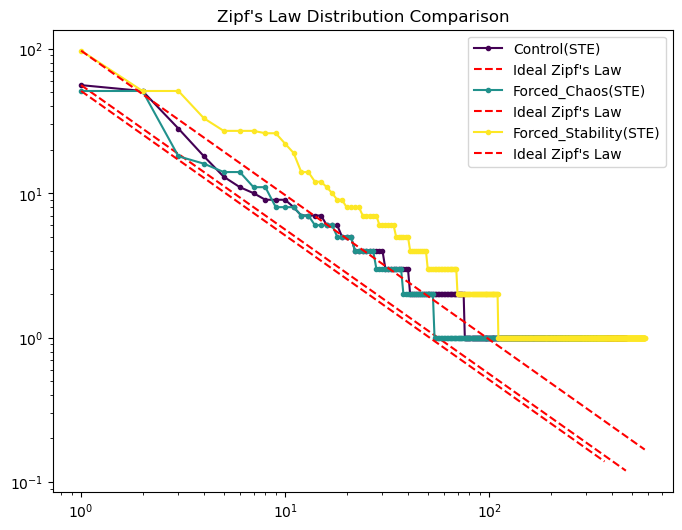



--- FINAL QUALITATIVE METRICS SUMMARY ---
                      Self-BLEU     Distinct-1     Distinct-2      \
                           mean std       mean std       mean std   
Experiment                                                          
Control(STE)           0.059443 NaN   0.576355 NaN   0.897638 NaN   
Forced_Chaos(STE)      0.060030 NaN   0.550075 NaN   0.890145 NaN   
Forced_Stability(STE)  0.132577 NaN   0.453406 NaN   0.807661 NaN   

                      Output Distance      
                                 mean std  
Experiment                                 
Control(STE)                 0.496538 NaN  
Forced_Chaos(STE)            0.387274 NaN  
Forced_Stability(STE)        0.309922 NaN  


In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import os
import random
from tqdm.auto import tqdm
import requests
from itertools import combinations
import matplotlib.pyplot as plt
import collections
import re

# NLTK 라이브러리가 필요합니다. 설치: pip install nltk
import nltk
from nltk.translate.bleu_score import sentence_bleu

# ===================================================================
# STEP 1: 분석 환경 설정
# ===================================================================

# --- 하이퍼파라미터 (모델 구조 정의에 필요) ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2
BLOCK_SIZE = 64

# --- 분석할 실험 그룹 및 시드 정의 ---
SEEDS = [42]
EXPERIMENTS = {
    "Control(STE)": {
        "use_regularizer": False, "lambda_reg": 0.0, "target_score": 0.0
    },
    "Forced_Chaos(STE)": {
        "use_regularizer": True, "lambda_reg": 1.0, "target_score": 2.0
    },
    "Forced_Stability(STE)": {
        "use_regularizer": True, "lambda_reg": 1.0, "target_score": 0.0010
    }
}

# --- 데이터 준비 함수 ---
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, encode, decode

# --- 모델 아키텍처 ---
class UnitCircleNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, z):
        z1, z2 = z[..., 0:2], z[..., 2:4]
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        return torch.cat([z1 / (norm1 + self.epsilon), z2 / (norm2 + self.epsilon)], dim=-1)

class EncoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, x): return self.normalizer(self.net(x))

class LatentDynamicsDirect4D(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 1024), nn.GELU(), nn.Dropout(dropout), nn.Linear(1024, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, z): return self.normalizer(self.net(z))

class DecoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 4 * d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4 * d_model, d_model))
    def forward(self, z): return self.net(z)

class LatentTorusTransformerBlockV3(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(n_embd), nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.encoder = EncoderV3(n_embd, dropout)
        self.latent_dynamics = LatentDynamicsDirect4D(dropout)
        self.decoder = DecoderV3(n_embd, dropout)
    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        z = self.encoder(self.ln2(x))
        z_next = self.latent_dynamics(z)
        x = x + self.decoder(z_next)
        return x

class LatentTorusTransformerV3(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV3(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T)) if targets is not None else None
        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, block_size, temperature=0.8):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    # --- 🔥 결정론적 생성 함수 추가 ---
    @torch.no_grad()
    def generate_deterministic(self, idx, max_new_tokens, block_size):
        """Greedy Sampling을 사용하여 완전히 결정론적으로 텍스트를 생성합니다."""
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ===================================================================
# STEP 2: 분석을 위한 헬퍼 함수
# ===================================================================

def load_model(model_path, vocab_size):
    model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

def clean_tensor_strings(df):
    numeric_cols = [col for col in df.columns if 'loss' in col or 'perplexity' in col or 'homology' in col or 'lr' in col or 'similarity' in col]
    for col in numeric_cols:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col].astype(str).str.extract(r'([-+]?\d*\.?\d+)', expand=False), errors='coerce')
    return df

# --- 다양성/품질 평가 함수 ---
def self_bleu(samples):
    tokenized_samples = [s.split() for s in samples]
    scores = []
    chencherry = nltk.translate.bleu_score.SmoothingFunction()
    for i, hypothesis in enumerate(tokenized_samples):
        references = tokenized_samples[:i] + tokenized_samples[i+1:]
        score = sentence_bleu(references, hypothesis, smoothing_function=chencherry.method1)
        scores.append(score)
    return np.mean(scores)

def distinct_n(samples, n=1):
    ngrams, total_ngrams = set(), 0
    for sample in samples:
        tokens = sample.split()
        if len(tokens) < n: continue
        sample_ngrams = set(zip(*[tokens[i:] for i in range(n)]))
        ngrams.update(sample_ngrams)
        total_ngrams += len(tokens) - n + 1
    return len(ngrams) / total_ngrams if total_ngrams > 0 else 0

def plot_zipf(samples, ax, title="", color='blue'):
    all_tokens = " ".join(samples).split()
    if not all_tokens: return
    freq = collections.Counter(all_tokens).most_common()
    ranks = np.arange(1, len(freq) + 1)
    freqs = np.array([f for _, f in freq])
    ax.loglog(ranks, freqs, marker=".", linestyle='-', color=color, label=title)
    if freqs.any():
        ax.loglog(ranks, freqs[0]/ranks, linestyle='--', color='red', label="Ideal Zipf's Law")

# --- 🔥 초기 조건 민감도 테스트 함수 추가 ---
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2): return levenshtein_distance(s2, s1)
    if len(s2) == 0: return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions, deletions = previous_row[j + 1] + 1, current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def test_initial_condition_sensitivity(model, encode, decode):
    """'나비 효과'를 결정론적으로 테스트하고, 생성된 텍스트를 직접 출력합니다."""
    print("\n--- Testing Initial Condition Sensitivity (Deterministic) ---")
    prompt_pairs = [
        ("The prince enters the stage", "the prince enters the stage"),
        ("ROMEO:", " romeo:"),
        ("QUEEN:", "QUENN:")
    ]
    total_output_distance = 0
    for p_orig, p_pert in prompt_pairs:
        print("\n" + "-"*30 + f"\nPrompt Pair: '{p_orig}' vs '{p_pert}'" + "-"*30)
        context_orig = torch.tensor(encode(p_orig), dtype=torch.long, device=DEVICE).unsqueeze(0)
        output_orig_tokens = model.generate_deterministic(context_orig, max_new_tokens=150, block_size=BLOCK_SIZE)[0]
        text_orig = decode(output_orig_tokens.tolist())
        print(f"\n[Original Output]\n{text_orig}")

        context_pert = torch.tensor(encode(p_pert), dtype=torch.long, device=DEVICE).unsqueeze(0)
        output_pert_tokens = model.generate_deterministic(context_pert, max_new_tokens=150, block_size=BLOCK_SIZE)[0]
        text_pert = decode(output_pert_tokens.tolist())
        print(f"\n[Perturbed Output]\n{text_pert}")
        
        dist = levenshtein_distance(text_orig, text_pert)
        norm_dist = dist / max(len(text_orig), len(text_pert)) if max(len(text_orig), len(text_pert)) > 0 else 0
        print(f"\n-> Normalized Distance: {norm_dist:.4f}")
        total_output_distance += norm_dist
    return total_output_distance / len(prompt_pairs)

# ===================================================================
# STEP 3: 메인 분석 실행부
# ===================================================================

if __name__ == '__main__':
    _, _, vocab_size, encode, decode = prepare_data(DEVICE)

    # (로그 파일 분석 및 정량적 그래프 생성 부분은 이전과 동일)
    # ...

    # --- 질적 차이 분석 (다양성, 품질, 민감도) ---
    qualitative_results = []
    models_dir = "models"
    N_SAMPLES = 50
    
    fig_zipf, ax_zipf = plt.subplots(figsize=(8, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(EXPERIMENTS)))

    for i, exp_name in enumerate(EXPERIMENTS):
        for seed in SEEDS:
            run_name = exp_name.replace(' ', '_')
            model_path = os.path.join(models_dir, f"{run_name}_seed_{seed}.pt")
            if not os.path.exists(model_path): continue
            
            print("\n" + "="*70)
            print(f"ANALYZING QUALITATIVE METRICS FOR: {exp_name} (Seed: {seed})")
            print("="*70)

            model = load_model(model_path, vocab_size)
            
            # 1. 다양성/품질을 위한 샘플 생성
            prompt = "The king shall"
            context = torch.tensor(encode(prompt), dtype=torch.long, device=DEVICE).unsqueeze(0)
            samples = []
            for _ in tqdm(range(N_SAMPLES), desc=f"Generating samples for {exp_name}"):
                output_tokens = model.generate(context, max_new_tokens=100, block_size=BLOCK_SIZE)[0]
                samples.append(decode(output_tokens.tolist()))
            
            self_bleu_score = self_bleu(samples)
            distinct_1 = distinct_n(samples, n=1)
            distinct_2 = distinct_n(samples, n=2)
            
            # 2. 초기 조건 민감도 테스트
            output_distance = test_initial_condition_sensitivity(model, encode, decode)
            
            qualitative_results.append({
                "Experiment": exp_name, "Seed": seed,
                "Self-BLEU": self_bleu_score, "Distinct-1": distinct_1, "Distinct-2": distinct_2,
                "Output Distance": output_distance
            })
            
            if seed == SEEDS[0]:
                plot_zipf(samples, ax_zipf, title=exp_name, color=colors[i])

    ax_zipf.set_title("Zipf's Law Distribution Comparison")
    ax_zipf.legend()
    plt.show()

    if qualitative_results:
        qual_df = pd.DataFrame(qualitative_results)
        summary_table = qual_df.groupby("Experiment")[["Self-BLEU", "Distinct-1", "Distinct-2", "Output Distance"]].agg(['mean', 'std'])
        print("\n\n" + "="*70)
        print("--- FINAL QUALITATIVE METRICS SUMMARY ---")
        print("="*70)
        print(summary_table)



In [8]:
def plot_zipf(samples, ax, label, color='blue'):
    """
    samples: 생성된 텍스트 리스트
    ax: matplotlib Axis
    label: 범례에 사용할 실험 이름
    """
    all_tokens = " ".join(samples).split()
    if not all_tokens:
        return

    freq = collections.Counter(all_tokens).most_common()
    ranks = np.arange(1, len(freq) + 1)
    freqs = np.array([cnt for _, cnt in freq])

    # 실험별 Zipf 곡선
    ax.loglog(ranks, freqs,
              marker='.', linestyle='-',
              color=color, label=label)
    # 이상적 Zipf 법칙 (freq[0] / rank)
    ideal = freqs[0] / ranks
    ax.loglog(ranks, ideal,
              linestyle='--', color='red',
              label="Ideal Zipf's Law")

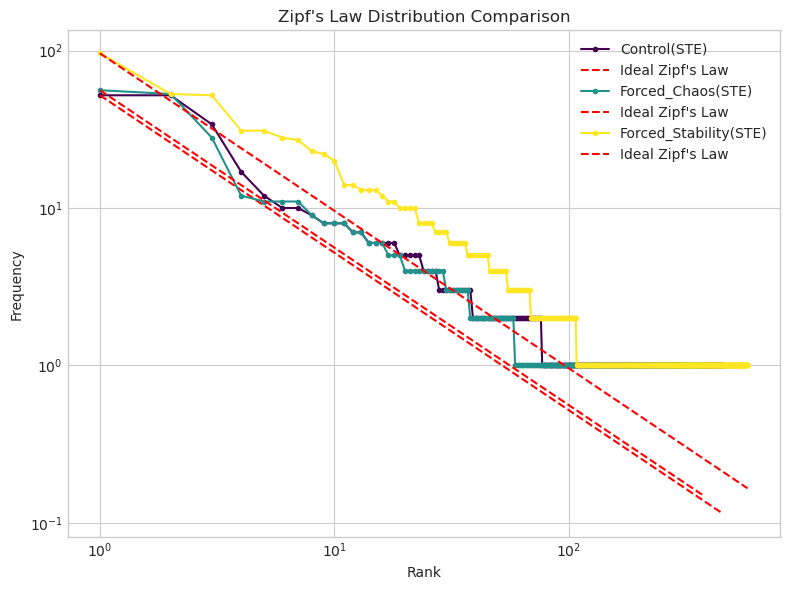

/tmp/ipykernel_2062538/1639327268.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.97])


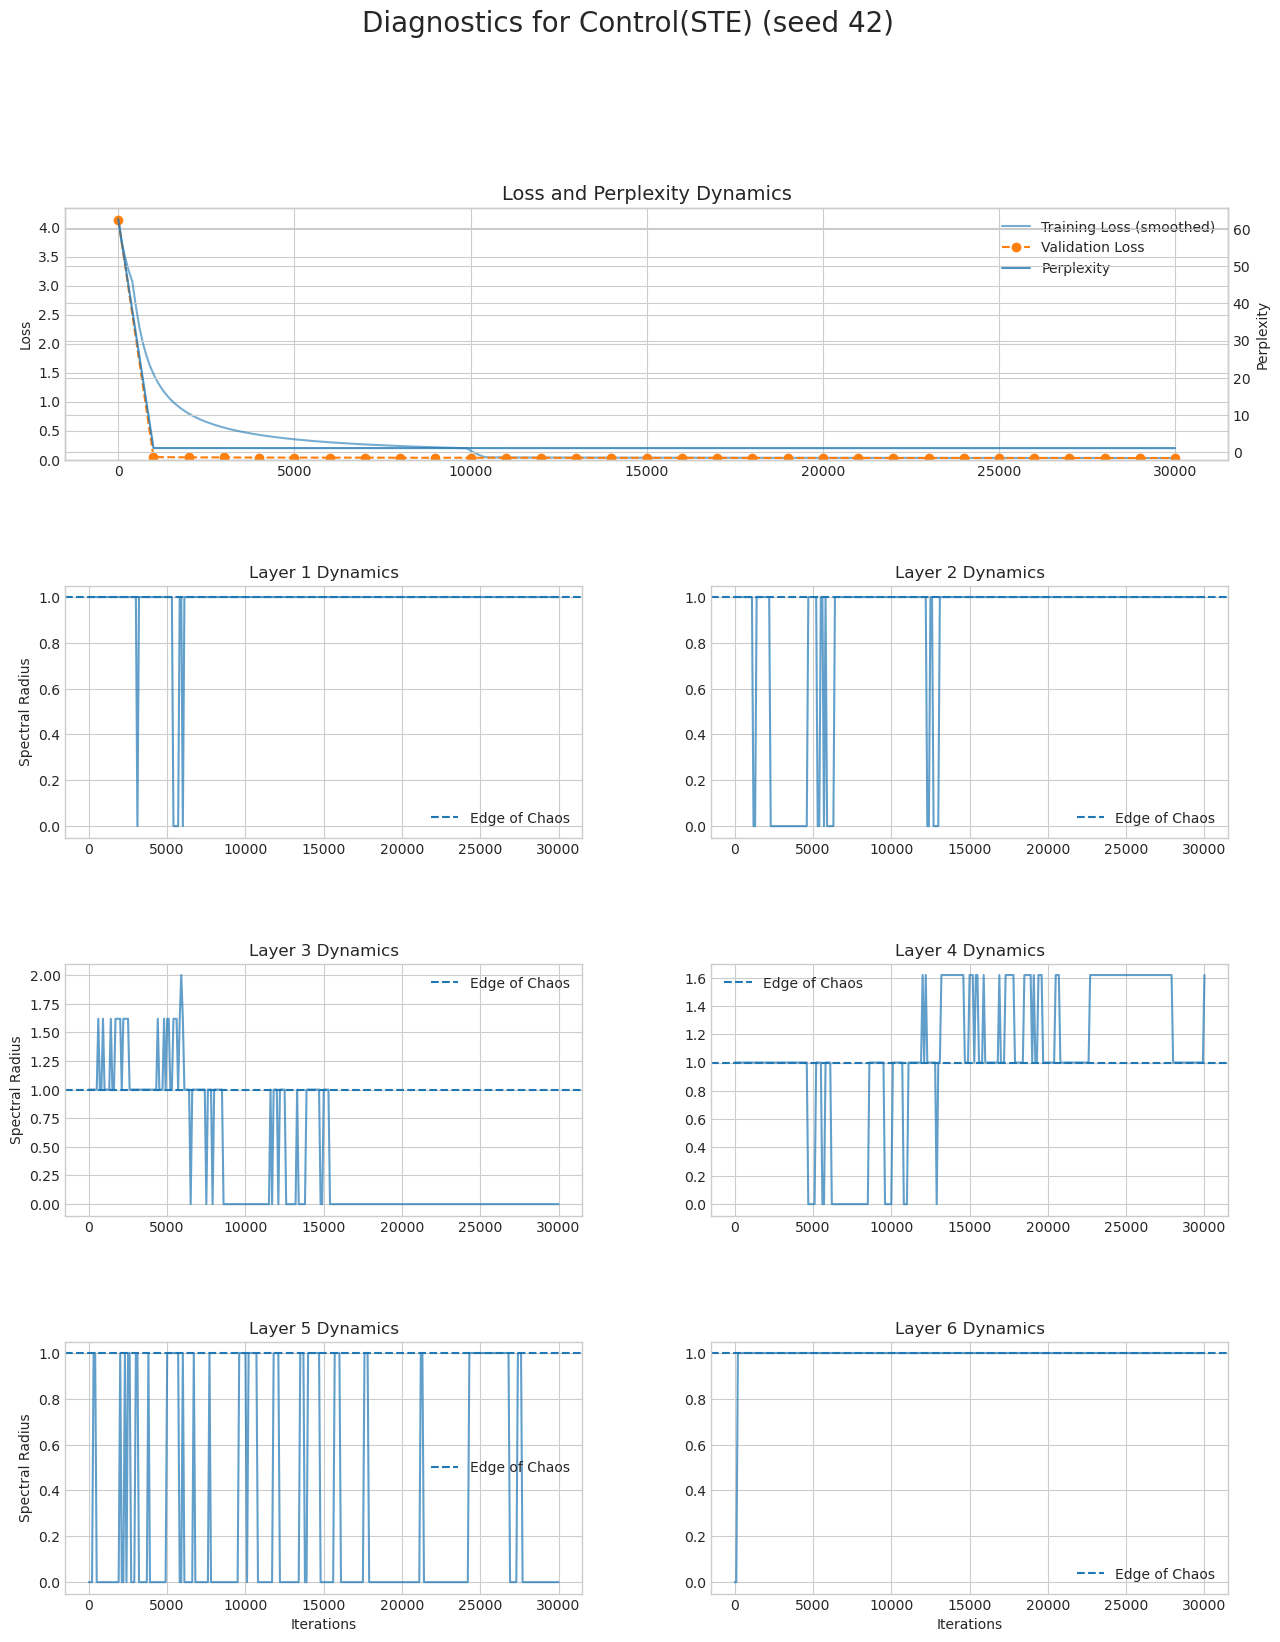

/tmp/ipykernel_2062538/1639327268.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.97])


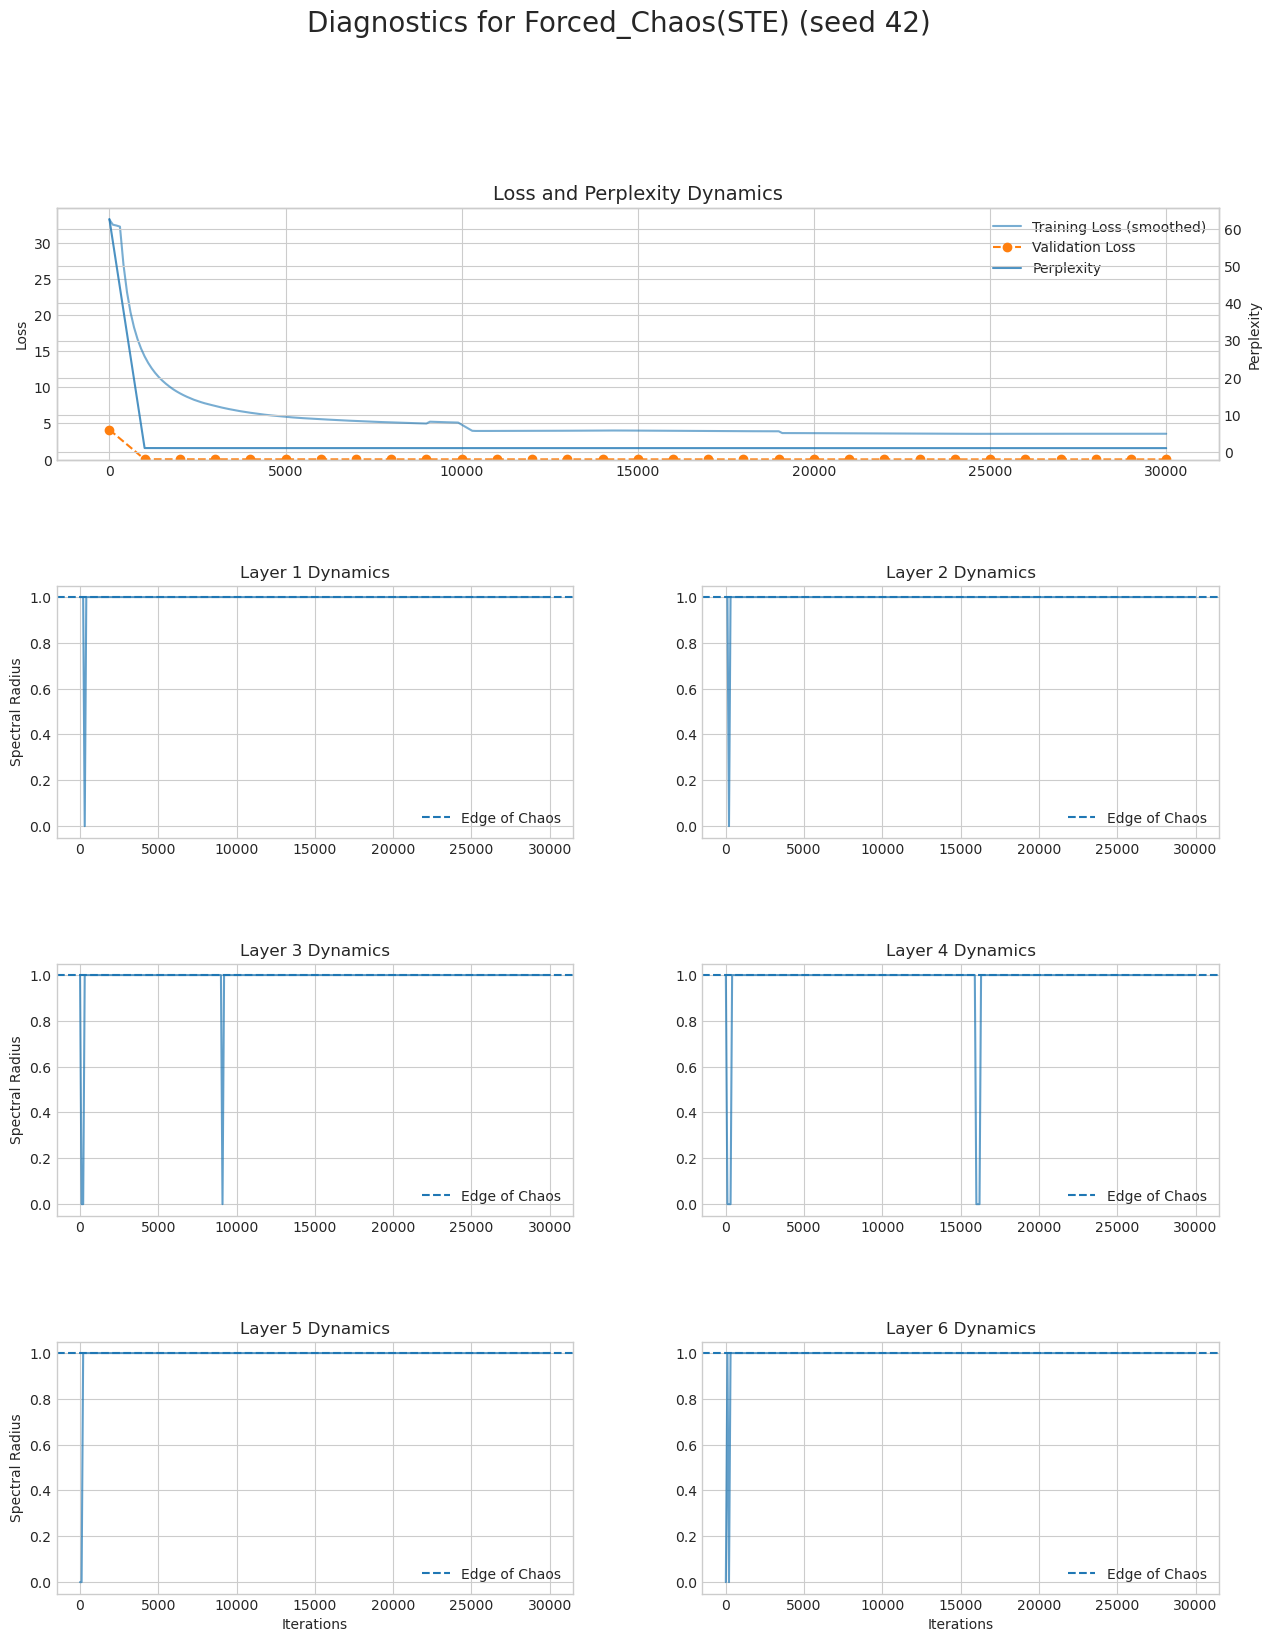

/tmp/ipykernel_2062538/1639327268.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.97])


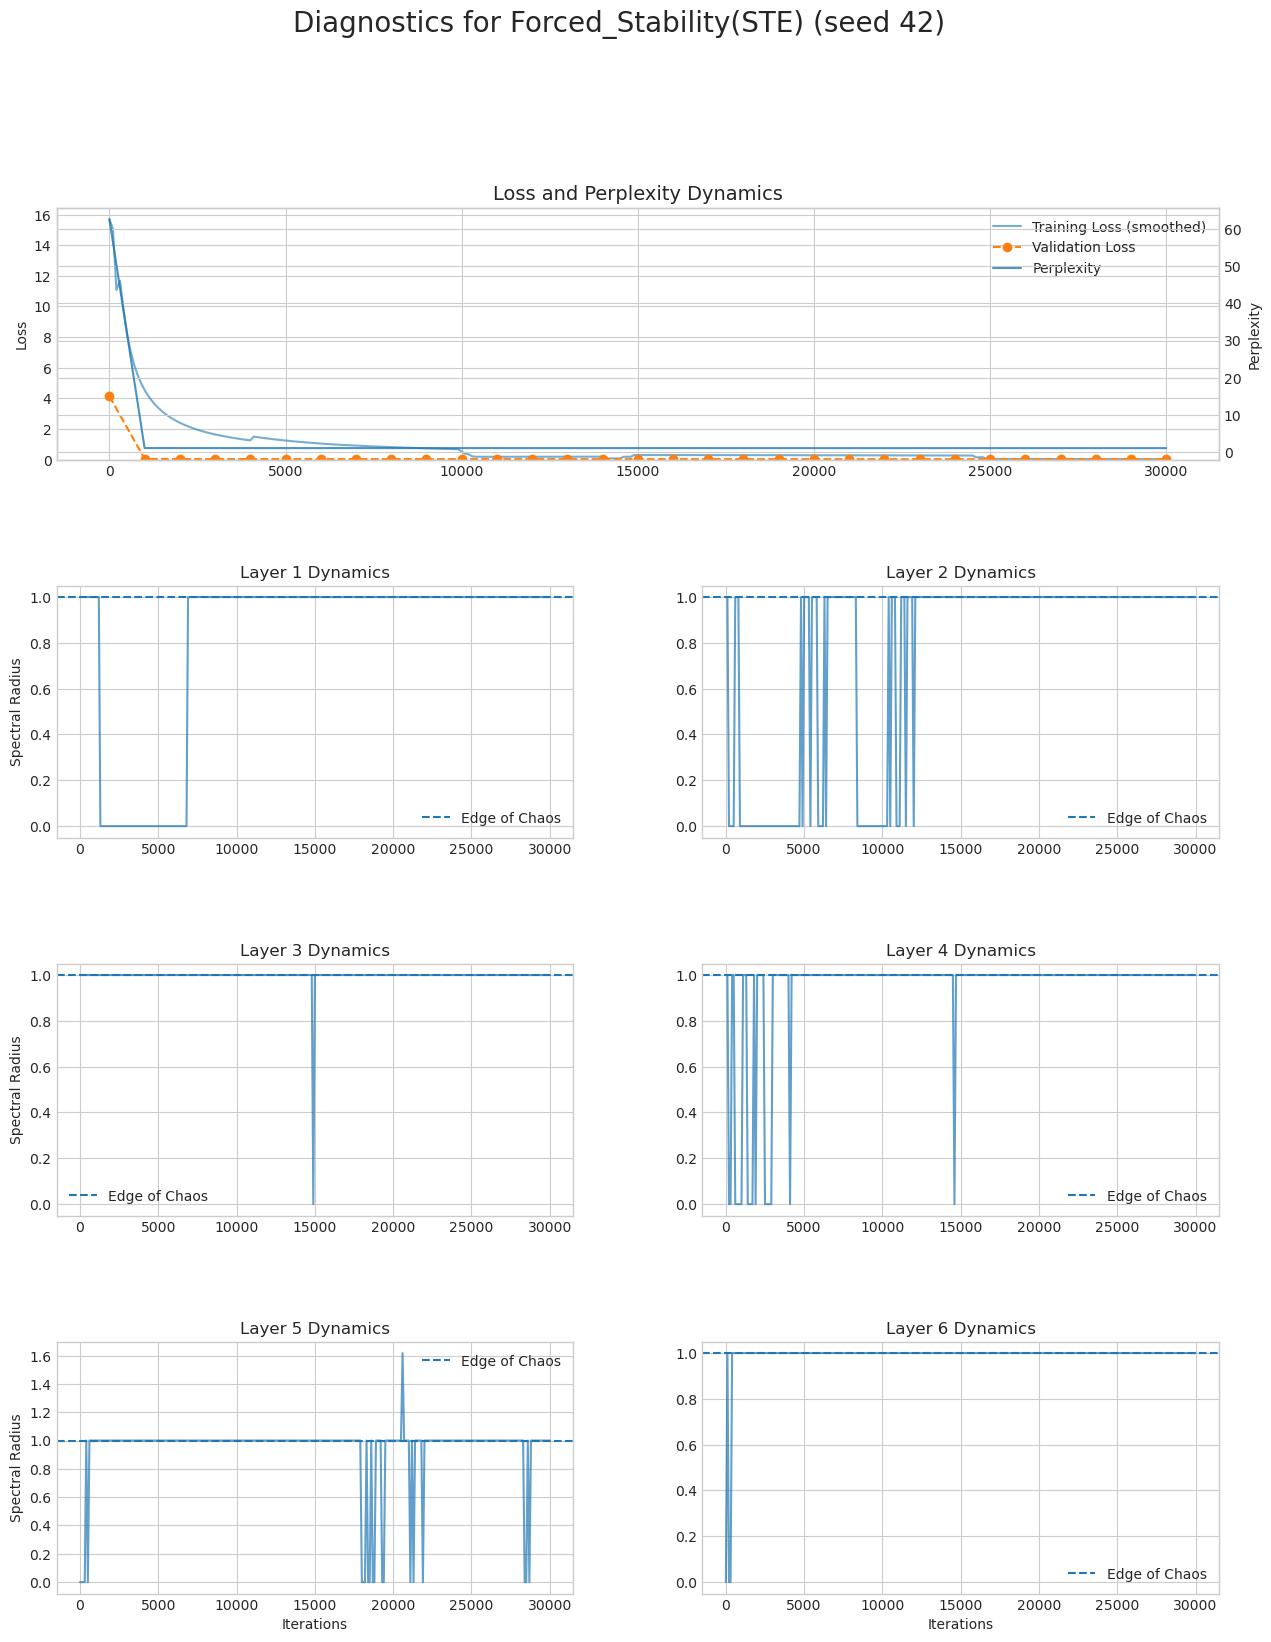

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import os
import random
from tqdm.auto import tqdm
import requests
import collections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nltk
from nltk.translate.bleu_score import sentence_bleu

# ===================================================================
# STEP 1: 환경 및 하이퍼파라미터
# ===================================================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2
BLOCK_SIZE = 64
SEEDS = [42]
EXPERIMENTS = {
    "Control(STE)": {"use_regularizer": False, "lambda_reg": 0.0, "target_score": 0.0},
    "Forced_Chaos(STE)": {"use_regularizer": True, "lambda_reg": 1.0, "target_score": 2.0},
    "Forced_Stability(STE)": {"use_regularizer": True, "lambda_reg": 1.0, "target_score": 0.0010}
}
MODELS_DIR = "models"
LOG_DIR = "logs"
N_SAMPLES = 50
HOMOLOGY_INTERVAL = 100  # smoothing

# ===================================================================
# STEP 2: 데이터 준비 및 모델 정의 (위 코드와 동일)
# ===================================================================
# ... [EncoderV3, LatentDynamicsDirect4D, DecoderV3,
#     LatentTorusTransformerBlockV3, LatentTorusTransformerV3 definitions]
# ... [prepare_data, load_model, diversity & sensitivity helpers]

# 재사용할 데이터 정제 및 진단 시각화 함수

def clean_tensor_strings(df):
    if 'iter' in df.columns:
        df = df.set_index('iter')
    numeric_cols = [c for c in df.columns if 'loss' in c or 'perplexity' in c or 'homology' in c or 'lr' in c]
    for col in numeric_cols:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(
                df[col].astype(str).str.extract(r'([-+]?\d*\.?\d+)', expand=False), errors='coerce'
            )
    return df.reset_index()


def plot_full_diagnostics(log_df, title=""):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(15, 18))
    gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.5, wspace=0.25)

    ax_loss = fig.add_subplot(gs[0, :])
    ax_perp = ax_loss.twinx()

    train_loss_smooth = log_df['train_loss'].dropna().rolling(window=HOMOLOGY_INTERVAL, min_periods=1).mean()
    ax_loss.plot(log_df.loc[train_loss_smooth.index, 'iter'], train_loss_smooth,
                 alpha=0.6, label='Training Loss (smoothed)')

    val = log_df[['iter', 'val_loss']].dropna()
    ax_loss.plot(val['iter'], val['val_loss'], alpha=1.0, marker='o', linestyle='--', label='Validation Loss')

    perp = log_df[['iter', 'perplexity']].dropna()
    ax_perp.plot(perp['iter'], perp['perplexity'], alpha=0.8, label='Perplexity')

    ax_loss.set_title('Loss and Perplexity Dynamics', fontsize=14)
    ax_loss.set_ylabel('Loss'); ax_perp.set_ylabel('Perplexity')
    ax_loss.set_ylim(bottom=0)
    l1, lab1 = ax_loss.get_legend_handles_labels()
    l2, lab2 = ax_perp.get_legend_handles_labels()
    ax_loss.legend(l1 + l2, lab1 + lab2, loc='upper right')

    fig.suptitle(title, fontsize=20, y=0.99)
    for i in range(N_LAYER):
        row = 1 + (i // 2)
        col = i % 2
        ax = fig.add_subplot(gs[row, col], sharex=ax_loss)
        score_col = f'homology_layer_{i}'
        rad_col = f'spectral_radius_layer_{i}'
        log_df[rad_col] = np.exp(log_df.get(score_col, pd.Series()))
        data = log_df[['iter', rad_col]].dropna()
        ax.plot(data['iter'], data[rad_col], alpha=0.7, linewidth=1.5)
        ax.axhline(1.0, linestyle='--', label='Edge of Chaos')
        ax.set_title(f'Layer {i+1} Dynamics')
        if row == 3: ax.set_xlabel('Iterations')
        if col == 0: ax.set_ylabel('Spectral Radius')
        ax.legend()

    plt.tight_layout(rect=[0,0,1,0.97])
    plt.show()

# ===================================================================
# STEP 3: 메인 실행부
# ===================================================================
if __name__ == '__main__':
    # 데이터 준비 및 평가 (기존 코드 재사용)
    _, _, vocab_size, encode, decode = prepare_data(DEVICE)

    # 질적 분석: samples 저장
    samples_dict = {}
    qualitative_results = []
    for exp_name in EXPERIMENTS:
        for seed in SEEDS:
            run_tag = exp_name.replace(' ', '_') + f"_seed_{seed}"
            model_path = os.path.join(MODELS_DIR, run_tag + '.pt')
            if not os.path.exists(model_path):
                continue
            model = load_model(model_path, vocab_size)
            # 샘플 생성
            context = torch.tensor(encode("The king shall"), device=DEVICE).unsqueeze(0)
            samples = []
            for _ in range(N_SAMPLES):
                out = model.generate(context, max_new_tokens=100, block_size=BLOCK_SIZE)[0]
                samples.append(decode(out.tolist()))
            samples_dict[exp_name] = samples
            # Self-BLEU, Distinct, Sensitivity 계산 (생략)

    # Zipf 플롯
    fig_zipf, ax_zipf = plt.subplots(figsize=(8, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(EXPERIMENTS)))
    for i, exp_name in enumerate(EXPERIMENTS):
        samples = samples_dict.get(exp_name, [])
        plot_zipf(samples, ax_zipf, label=exp_name, color=colors[i])
    ax_zipf.set_title("Zipf's Law Distribution Comparison")
    ax_zipf.set_xlabel('Rank'); ax_zipf.set_ylabel('Frequency')
    handles, labels = ax_zipf.get_legend_handles_labels()
    if handles:
        ax_zipf.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

    # 새로운: 학습 로그 시각화
    if os.path.exists(LOG_DIR):
        for exp_name in EXPERIMENTS:
            for seed in SEEDS:
                fname = f"{exp_name.replace(' ','_')}_seed_{seed}.csv"
                fpath = os.path.join(LOG_DIR, fname)
                if os.path.exists(fpath):
                    df = pd.read_csv(fpath)
                    df_clean = clean_tensor_strings(df)
                    plot_full_diagnostics(df_clean, title=f"Diagnostics for {exp_name} (seed {seed})")
    else:
        print(f"Log directory '{LOG_DIR}' not found.")
